In [ ]:
# pip install matplotlib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from pathlib import Path
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, LeakyReLU, ReLU , Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback


2024-07-03 12:19:39.029200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 12:19:39.029249: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 12:19:39.030720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 12:19:39.044422: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
folder ="/workspace/JPG_Images/photo"
folder_path = folder
output_folder = '/workspace/outputfolder/'

In [3]:
# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

In [4]:
for name in os.listdir(folder_path):
    print(name)

PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103815835_114_S180778_I355962.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171521284_156_S1161815_I1624166.jpg
PPMI_103542_MR_rsfMRI_LR__br_raw_20220106125408351_5_S1093544_I1530517.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171603573_138_S1161815_I1624166.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171527670_154_S1161815_I1624166.jpg
PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103805789_122_S180778_I355962.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171459129_49_S1161815_I1624166.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171540345_80_S1161815_I1624166.jpg
PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103809595_132_S180778_I355962.jpg
PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103814243_51_S180778_I355962.jpg
PPMI_3130_MR_ep2d_RESTING_STATE_br_raw_20130124103807052_120_S180778_I355962.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171551076_21_S1161815_I1624166.jpg
PPMI_160890_MR_rsfMRI_RL__br_raw_20220929171511555_34_S1161815

In [5]:
def data_load(folder_path):
    images = []
    for name in os.listdir(folder_path):
        if name.lower().endswith('.jpg') or name.lower().endswith('.jpeg'):
            img_path = os.path.join(folder_path, name)
            img = Image.open(img_path)
            img = img.resize((224, 224))
            img_array = np.array(img)
            if img_array.ndim == 2:
                img_array = img_array[:, :, np.newaxis]
            elif img_array.shape[2] == 3:
                
                img_array = img_array[:, :, np.newaxis]
            images.append(img_array)

    images_tensors = [tf.convert_to_tensor(img, dtype=tf.float32) for img in images]
    dataset = tf.data.Dataset.from_tensor_slices(images_tensors)
    return dataset


2024-07-03 12:20:55.163694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16356 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:b7:00.0, compute capability: 8.0


(224, 224, 1)


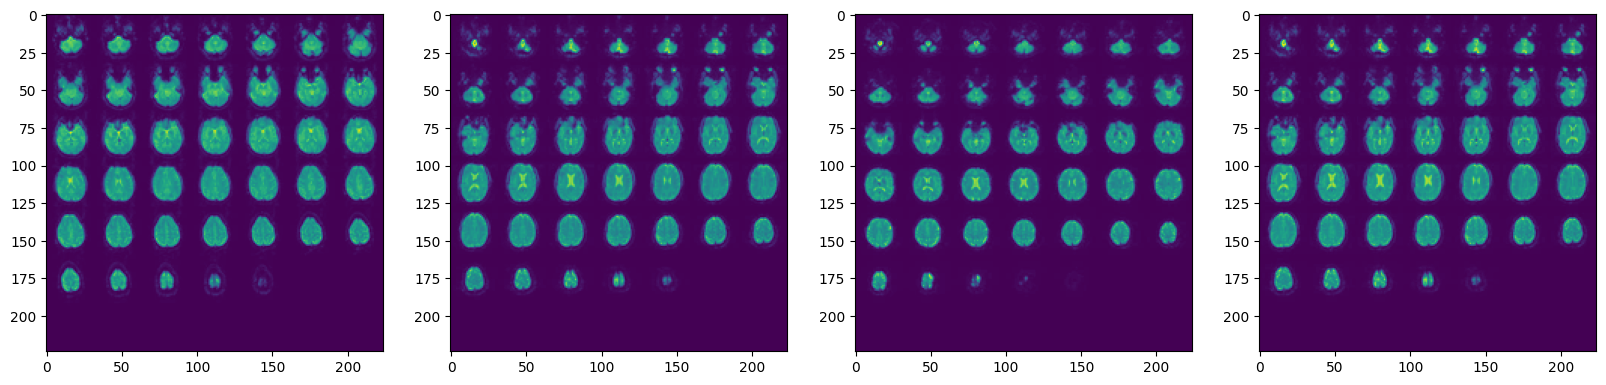

In [6]:
dataset = data_load(folder_path)
dataiterator = dataset.as_numpy_iterator()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample))

print(dataset.as_numpy_iterator().next().shape)
BATCH_SIZE = 64

In [7]:
train_dataset = dataset

In [8]:
def scale_images(data): 
    image = data
    return image / 255

dataset = dataset.map(scale_images)
dataset = dataset.cache()
dataset = dataset.shuffle(318)
dataset = dataset.batch(62)
dataset = dataset.prefetch(64)

print(dataset.as_numpy_iterator().next().shape)

(62, 224, 224, 1)


In [9]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [10]:
train_dataset = dataset

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 1024)))
    assert model.output_shape == (None, 7, 7, 1024)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 28, 28, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 56, 56, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 112, 112,32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 224, 224, 1)

    return model

In [12]:
generator = make_generator_model()

2024-07-03 12:21:01.316249: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 50176)             5017600   
                                                                 
 batch_normalization_6 (Bat  (None, 50176)             200704    
 chNormalization)                                                
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 50176)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 1024)        0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 7, 7, 512)         13107200  
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 7, 512)        

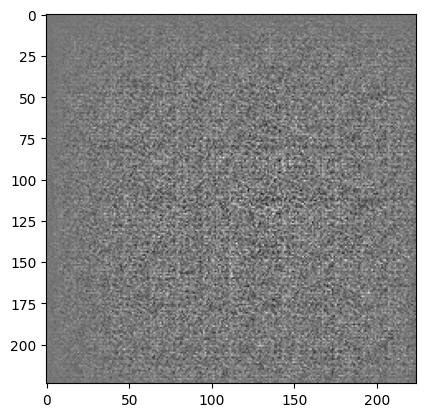

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
generator.summary()

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[224, 224, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Conv2D(14, (5, 5), strides=(2, 2), padding='same',
#                                      input_shape=[224, 224, 1]))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
#     model.add(layers.Conv2D(28, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
#     model.add(layers.Conv2D(56, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(112, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Conv2D(224, (5, 5), strides=(2, 2), padding='same'))
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

# #     model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
# #     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.3))
    
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1))

#     return model

In [16]:
discriminator  = make_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 32)      832       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 112, 112, 32)      0         
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 56, 56, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)      

In [17]:
# discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[2.254529e-05]], shape=(1, 1), dtype=float32)


In [18]:
# discriminator = discriminator_model()

In [19]:
# This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [38]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

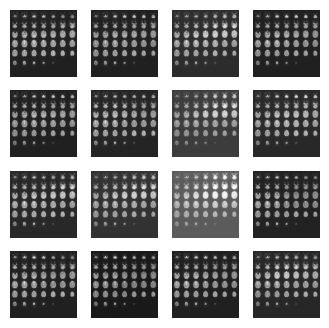

In [39]:
train(train_dataset, EPOCHS)

In [27]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs):
  # A. For each epoch, do the following:
  for epoch in range(epochs):
    start = time.time()
    # 1 - For each batch of the epoch, 
    for image_batch in dataset:
      # 1.a - run the custom "train_step" function
      # we just declared above
      train_step(image_batch)

    # 2 - Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 3 - Save the model every 5 epochs as 
    # a checkpoint, which we will use later
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # 4 - Print out the completed epoch no. and the time spent
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # B. Generate a final image after the training is completed
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

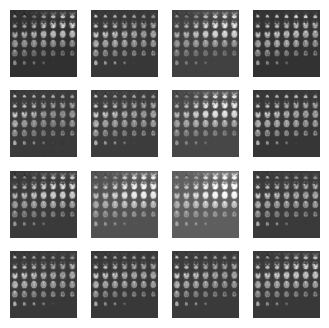

In [29]:
EPOCHS = 100
train(train_dataset, EPOCHS)

In [ ]:
hist = fashgan.fit(dataset, epochs=2, callbacks=[ModelMonitor()])
generator.save('generator.h5')
discriminator.save('discriminator.h5')
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()